In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [8]:
# Load the dataset
df = pd.read_csv('TSLA.csv')

end_date = datetime.datetime.now() 
start_date = end_date - datetime.timedelta(days = 365 * 5)
stock_data = yf.download('TSLA', start=start_date.date(), end=end_date.date())

# Use only the 'Close' column
data = pd.DataFrame(stock_data[['Open', 'Close', 'High', 'Low']].values, columns=['Open', 'Close', 'High', 'Low'])

n_periods = 5
sma = data['Close'].rolling(window=n_periods).mean()
data['SMA'] = sma

short_ema = data['Close'].ewm(span=12, adjust=False).mean()
long_ema = data['Close'].ewm(span=26, adjust=False).mean()

macd_line = short_ema - long_ema
signal_line = macd_line.ewm(span=9, adjust=False).mean()
macd_histogram = macd_line - signal_line

data['MACD'] = macd_line
data['Signal_Line'] = signal_line
data['MACD_Histogram'] = macd_histogram
data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 1])
    return np.array(dataX), np.array(dataY)

# Define time step and split data
time_step = 100
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Reshape input to be [samples, time steps, features]
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 8)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 8)

[*********************100%***********************]  1 of 1 completed
(922, 100, 8)
(231, 100, 8)
(922,)
(231,)


In [9]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

train_indices = []
test_indices = []

for train_index, test_index in tscv.split(X_train):
    train_indices.append(train_index)
    test_indices.append(test_index)

for i in range(n_splits):
    X_train_fold, X_val_fold = X_train[train_indices[i]], X_train[test_indices[i]]
    y_train_fold, y_val_fold = y_train[train_indices[i]], y_train[test_indices[i]]


In [10]:
# Create and compile the GRU model
model = Sequential([
    GRU(50, input_shape=(100, 8)),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=60, validation_data=(X_val_fold, y_val_fold), verbose=1)

Epoch 1/100
16/16 [==============================] - 10s 178ms/step - loss: 0.0870 - val_loss: 0.0056
Epoch 2/100
16/16 [==============================] - 2s 104ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 3/100
16/16 [==============================] - 1s 58ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 4/100
16/16 [==============================] - 1s 70ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
16/16 [==============================] - 2s 103ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/100
16/16 [==============================] - 2s 99ms/step - loss: 8.5878e-04 - val_loss: 9.4748e-04
Epoch 7/100
16/16 [==============================] - 2s 97ms/step - loss: 7.4024e-04 - val_loss: 6.2180e-04
Epoch 8/100
16/16 [==============================] - 2s 95ms/step - loss: 6.7643e-04 - val_loss: 7.0084e-04
Epoch 9/100
16/16 [==============================] - 2s 106ms/step - loss: 6.4346e-04 - val_loss: 6.6555e-04
Epoch 10/100
16/16 [==============================] - 1s 90ms/s

In [5]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error: ", mse)

temp = scaled_data[-231:]
temp[:, 1] = predictions.reshape(-1)
temp = scaler.inverse_transform(temp) # Undo scaling
predictions = temp[-231:, 1]

8/8 [==============================] - 2s 15ms/step
Mean Squared Error:  0.0002936285492901015


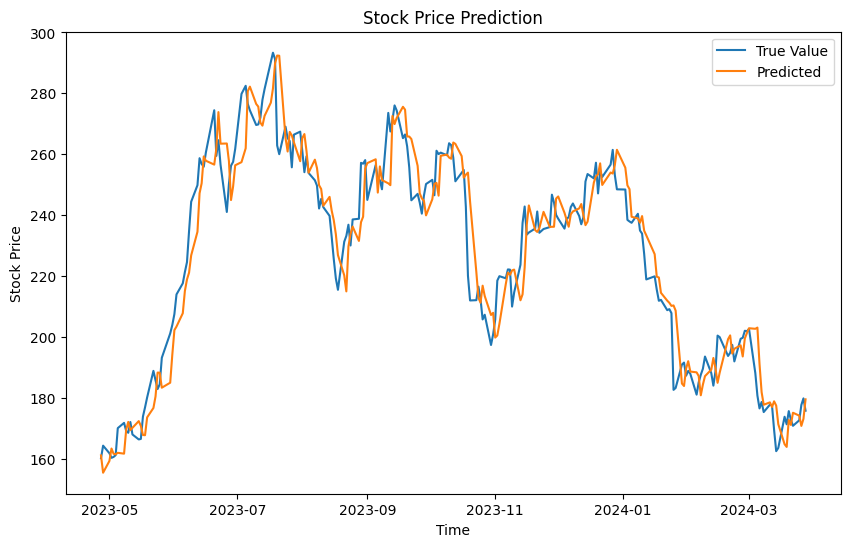

In [6]:
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[-232:], stock_data['Close'].tail(232), label='True Value')
plt.plot(stock_data.index[-232:], predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()